# Herschel Stripe 82 master catalogue
## Preparation of DECam Legacy Survey data

This catalogue comes from `dmu0_DECaLS`.

In the catalogue, we keep:

- The `object_id` as unique object identifier;
- The position;
- The g, r, i, z, Y aperture magnitude (for now in ????”);
- The g, r, i, z, Y kron fluxes and magnitudes.


In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
ceb6b33 (Wed Jun 28 18:07:57 2017 +0100) [with local modifications]


In [6]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

In [10]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "decals_ra"
DEC_COL = "decals_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        "objid": "decals_id",
        "ra": "decals_ra",
        "dec": "decals_dec",
        "decam_flux": "decam_flux_TEMP",
        "decam_flux_ivar": "decam_flux_ivar_TEMP",
        "decam_apflux": "decam_apflux_TEMP",
        "decam_apflux_ivar": "decam_apflux_ivar_TEMP",
       
    })


catalogue = Table.read("../../dmu0/dmu0_DECaLS/data/DECaLS_Herschel-Stripe-82.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2017

catalogue.add_column(Column(catalogue["decam_flux_TEMP"][:,0], name="f_decam_g"))
catalogue.add_column(Column(catalogue["decam_flux_TEMP"][:,1], name="f_decam_r"))
catalogue.add_column(Column(catalogue["decam_flux_TEMP"][:,2], name="f_decam_i"))
catalogue.add_column(Column(catalogue["decam_flux_TEMP"][:,3], name="f_decam_z"))
catalogue.add_column(Column(catalogue["decam_flux_TEMP"][:,4], name="f_decam_y"))

catalogue.add_column(Column(catalogue["decam_flux_ivar_TEMP"][:,0], name="ferr_decam_g"))
catalogue.add_column(Column(catalogue["decam_flux_ivar_TEMP"][:,1], name="ferr_decam_r"))
catalogue.add_column(Column(catalogue["decam_flux_ivar_TEMP"][:,2], name="ferr_decam_i"))
catalogue.add_column(Column(catalogue["decam_flux_ivar_TEMP"][:,3], name="ferr_decam_z"))
catalogue.add_column(Column(catalogue["decam_flux_ivar_TEMP"][:,4], name="ferr_decam_y"))

catalogue.add_column(Column(catalogue["decam_apflux_TEMP"][:,0], name="f_ap_decam_g"))
catalogue.add_column(Column(catalogue["decam_apflux_TEMP"][:,1], name="f_ap_decam_r"))
catalogue.add_column(Column(catalogue["decam_apflux_TEMP"][:,2], name="f_ap_decam_i"))
catalogue.add_column(Column(catalogue["decam_apflux_TEMP"][:,3], name="f_ap_decam_z"))
catalogue.add_column(Column(catalogue["decam_apflux_TEMP"][:,4], name="f_ap_decam_y"))

catalogue.add_column(Column(catalogue["decam_apflux_ivar_TEMP"][:,0], name="ferr_ap_decam_g"))
catalogue.add_column(Column(catalogue["decam_apflux_ivar_TEMP"][:,1], name="ferr_ap_decam_r"))
catalogue.add_column(Column(catalogue["decam_apflux_ivar_TEMP"][:,2], name="ferr_ap_decam_i"))
catalogue.add_column(Column(catalogue["decam_apflux_ivar_TEMP"][:,3], name="ferr_ap_decam_z"))
catalogue.add_column(Column(catalogue["decam_apflux_ivar_TEMP"][:,4], name="ferr_ap_decam_y"))

catalogue.remove_columns(["decam_flux_TEMP", 
                          "decam_flux_ivar_TEMP", 
                          "decam_apflux_TEMP", 
                          "decam_apflux_ivar_TEMP"])

# Clean table metadata
catalogue.meta = None

In [7]:
#TODO replace one column of fluxes with a column for each band

# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('f_'):
        
        errcol = "ferr{}".format(col[1:])
        mag, error = flux_to_mag(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(mag, name="m{}".format(col[1:])))
        catalogue.add_column(Column(error, name="m{}".format(errcol[1:])))
        
        # Band-flag column
        if 'ap' not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: divide by zero encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:80: RuntimeWarning: invalid value encountered in true_divide
  errors = 2.5 / np.log(10) * errors_on_fluxes / fluxes
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:80: RuntimeWarning: divide by zero encountered in true_divide
  errors = 2.5 / np.log(10) * errors_on_fluxes / fluxes


In [8]:
catalogue[:10].show_in_notebook()

idx,decals_id,decals_ra,decals_dec,f_decam_g,f_decam_r,f_decam_i,f_decam_z,f_decam_y,ferr_decam_g,ferr_decam_r,ferr_decam_i,ferr_decam_z,ferr_decam_y,f_ap_decam_g [8],f_ap_decam_r [8],f_ap_decam_i [8],f_ap_decam_z [8],f_ap_decam_y [8],ferr_ap_decam_g [8],ferr_ap_decam_r [8],ferr_ap_decam_i [8],ferr_ap_decam_z [8],ferr_ap_decam_y [8],m_decam_g,merr_decam_g,flag_decam_g,m_decam_r,merr_decam_r,flag_decam_r,m_decam_i,merr_decam_i,flag_decam_i,m_decam_z,merr_decam_z,flag_decam_z,m_decam_y,merr_decam_y,flag_decam_y,m_ap_decam_g [8],merr_ap_decam_g [8],m_ap_decam_r [8],merr_ap_decam_r [8],m_ap_decam_i [8],merr_ap_decam_i [8],m_ap_decam_z [8],merr_ap_decam_z [8],m_ap_decam_y [8],merr_ap_decam_y [8]
,,deg,deg,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,,,,,,,,,,,,,,,,,,,,,,,,,
0,162,351.490178887,-0.123836520221,0.0,0.373479,0.625727,0.0,2.07418,0.0,1411.56,543.389,0.0,99.2844,0.0 .. 0.0,0.0692131 .. 0.283776,0.163214 .. 0.84085,0.0 .. 0.0,0.596401 .. -0.197462,0.0 .. 0.0,18203.3 .. 92.8738,3814.74 .. 19.3562,0.0 .. 0.0,601.233 .. 2.87058,inf,nan,False,9.96933,4103.53,False,9.40904,942.866,False,inf,nan,False,8.10788,51.9707,False,inf .. inf,nan .. nan,11.7995 .. 10.2676,285552.0 .. 355.339,10.8681 .. 9.0882,25376.4 .. 24.9934,inf .. inf,nan .. nan,9.46116 .. nan,1094.53 .. -15.7837
1,185,351.497656789,-0.123166477786,0.0,0.072333,0.120181,0.0,0.251996,0.0,2068.29,1102.28,0.0,228.599,0.0 .. 0.0,0.0173222 .. -0.447781,0.0581042 .. -0.504469,0.0 .. 0.0,0.128148 .. -1.78948,0.0 .. 0.0,18203.3 .. 92.5239,3814.74 .. 18.1597,0.0 .. 0.0,601.233 .. 2.37544,inf,nan,False,11.7517,31045.5,False,11.2004,9958.24,False,inf,nan,False,10.3965,984.93,False,inf .. inf,nan .. nan,13.3035 .. nan,1.14096e+06 .. -224.343,11.9895 .. nan,71282.3 .. -39.0839,inf .. inf,nan .. nan,11.1307 .. nan,5093.95 .. -1.44125
2,203,351.489605175,-0.120873846416,0.0,29.2583,45.2401,0.0,54.0547,0.0,403.1,153.34,0.0,33.8825,0.0 .. 0.0,6.34626 .. 30.5853,22.01 .. 48.2632,0.0 .. 0.0,31.5973 .. 70.1662,0.0 .. 0.0,12405.7 .. 67.8317,2929.49 .. 15.1956,0.0 .. 0.0,234.994 .. 1.29856,inf,nan,False,5.23438,14.9585,False,4.76119,3.68009,False,inf,nan,False,4.56792,0.68056,False,inf .. inf,nan .. nan,6.8937 .. 5.18622,2122.4 .. 2.40793,5.54345 .. 4.69096,144.509 .. 0.341842,inf .. inf,nan .. nan,5.15088 .. 4.28468,8.07477 .. 0.0200936
3,204,351.491316815,-0.121504535184,0.0,0.558224,2.92876,0.0,20.7531,0.0,1933.77,689.469,0.0,56.4491,0.0 .. 0.0,0.120723 .. 21.2689,1.43671 .. 41.3169,0.0 .. 0.0,12.1009 .. 70.1267,0.0 .. 0.0,17980.1 .. 75.129,2929.49 .. 15.8101,0.0 .. 0.0,234.994 .. 1.46535,inf,nan,False,9.53298,3761.14,False,7.73329,255.597,False,inf,nan,False,5.6073,2.95324,False,inf .. inf,nan .. nan,11.1955 .. 5.58064,161705.0 .. 3.83519,8.50658 .. 4.85968,2213.84 .. 0.415462,inf .. inf,nan .. nan,6.19296 .. 4.28529,21.0844 .. 0.0226873
4,205,351.491875822,-0.120896680757,0.0,0.220627,1.13159,0.0,4.3251,0.0,1015.13,468.964,0.0,45.6911,0.0 .. 0.0,0.0455884 .. 2.89153,0.362048 .. 4.60417,0.0 .. 0.0,1.7112 .. 24.6851,0.0 .. 0.0,12777.4 .. 68.0715,2929.49 .. 15.2134,0.0 .. 0.0,234.994 .. 1.30316,inf,nan,False,10.5409,4995.6,False,8.76578,449.962,False,inf,nan,False,7.31001,11.4699,False,inf .. inf,nan .. nan,12.2529 .. 7.74718,304306.0 .. 25.56,10.0031 .. 7.24212,8785.16 .. 3.58755,inf .. inf,nan .. nan,8.31675 .. 5.41892,149.101 .. 0.0573176
5,224,351.49700635,-0.120688615954,0.0,0.190796,0.569623,0.0,2.04572,0.0,931.719,451.049,0.0,42.0976,0.0 .. 0.0,0.0461311 .. -0.354466,0.143672 .. 0.00315862,0.0 .. 0.0,0.645679 .. 1.37384,0.0 .. 0.0,11009.5 .. 65.9618,2929.49 .. 15.0669,0.0 .. 0.0,234.994 .. 1.26602,inf,nan,False,10.6986,5302.01,False,9.51104,859.727,False,inf,nan,False,8.12289,22.3427,False,inf .. inf,nan .. nan,12.24 .. nan,259117.0 .. -202.042,11.0066 .. 15.1513,22138.2 .. 5179.08,inf 

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [11]:
SORT_COLS = [] #TODO add order
FLAG_NAME = 'decals_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(
    catalogue, RA_COL, DEC_COL, 
    sort_col= SORT_COLS,
    flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 161282 sources.
The cleaned catalogue has 161218 sources (64 removed).
The cleaned catalogue has 64 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [12]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Herschel-Stripe-82.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

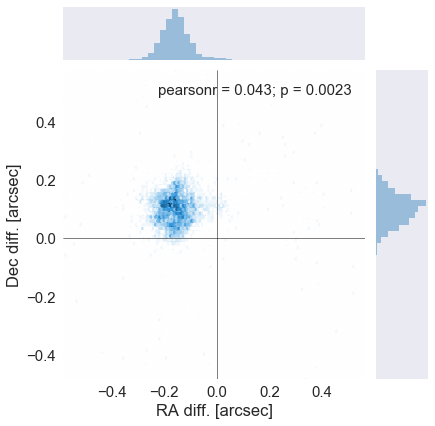

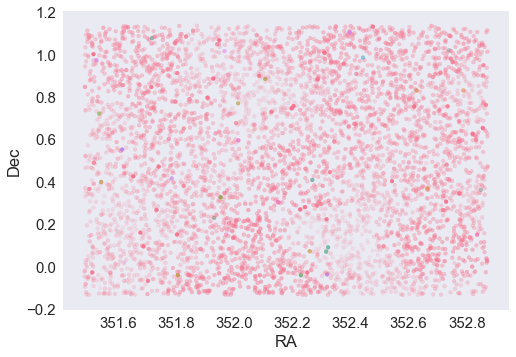

In [13]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [14]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.16003073272941037 arcsec
Dec correction: -0.10372309363364529 arcsec


In [15]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

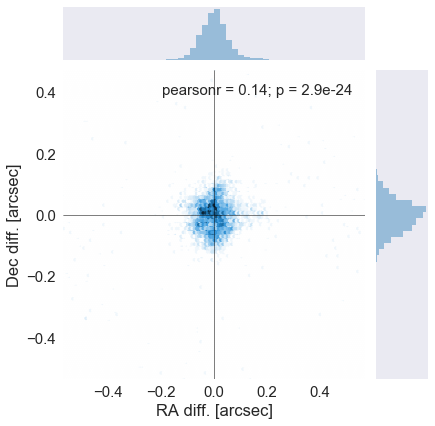

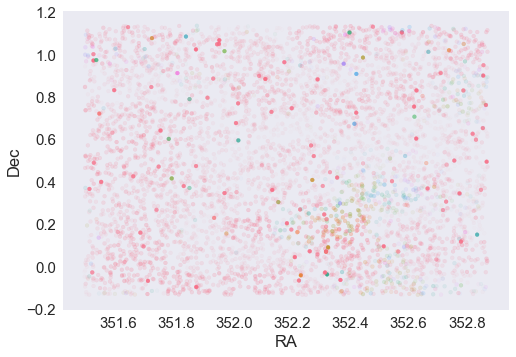

In [16]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [17]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [18]:
GAIA_FLAG_NAME = "decals_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

5166 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [19]:
catalogue.write("{}/DECaLS.fits".format(OUT_DIR), overwrite=True)